# Agricultural Crop Price Prediction - ML Training Notebook

**Developer**: Suraj Singh  
**Email**: surajsingh@gmail.com

---

## 📋 Objective
Train machine learning models to predict agricultural crop prices for different states in India.

## 🎯 Approach
1. Load and preprocess agricultural market data
2. Perform exploratory data analysis (EDA)
3. Engineer time-series features
4. Train Random Forest models for each crop-state combination
5. Export models for production use

## 📊 Dataset
- **Source**: Indian Agricultural Market Data
- **Records**: 297,000+ price observations
- **Crops**: Potato, Onion, Wheat, Tomato, Rice
- **States**: 20+ Indian states
- **Time Range**: Historical data from multiple years

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


## 1️⃣ Import Required Libraries
Import all necessary Python libraries for data processing, visualization, and machine learning.

In [2]:
df = pd.read_csv('Agriculture_price_dataset.csv')
df.head()

,STATE,District Name,Market Name,Commodity,Variety,Grade,Min_Price,Max_Price,Modal_Price,Price Date
0,Maharashtra,nashik,Lasalgaon(Niphad),Wheat,Maharashtra 2189,FAQ,2172.0,2399.0,2300.0,6/6/2023
1,Maharashtra,satara,Patan,Tomato,Other,FAQ,1000.0,1500.0,1250.0,6/6/2023
2,Uttar Pradesh,mainpuri,Bewar,Potato,Local,FAQ,800.0,820.0,810.0,6/6/2023
3,Rajasthan,chittorgarh,Nimbahera,Wheat,Other,FAQ,2040.0,2668.0,2300.0,6/6/2023
4,Rajasthan,pratapgarh,Pratapgarh,Onion,Other,FAQ,476.0,1043.0,617.0,6/6/2023


## 2️⃣ Load Dataset
Load the agricultural price dataset from CSV file.

In [3]:
# Step A1: find top crops by data availability
top_crops = df['Commodity'].value_counts()

print(top_crops)


Commodity
Potato    327332
Onion     298658
Wheat      76976
Tomato     26644
Rice        7782
Name: count, dtype: int64


## 3️⃣ Exploratory Data Analysis (EDA)

### Analyze Top Crops by Data Availability
Identify which crops have the most data points for training reliable models.

In [4]:
df1=df.copy()
df1.rename(columns={'Price Date':'Date','Modal_Price':'Price','Market Name':'Market','District Name':'District'},inplace=True)

df1.columns

Index(['STATE', 'District', 'Market', 'Commodity', 'Variety', 'Grade',
       'Min_Price', 'Max_Price', 'Price', 'Date'],
      dtype='object')

### Data Preprocessing - Column Renaming
Rename columns to shorter, more convenient names for easier data manipulation.

In [5]:
df1.head()

,STATE,District,Market,Commodity,Variety,Grade,Min_Price,Max_Price,Price,Date
0,Maharashtra,nashik,Lasalgaon(Niphad),Wheat,Maharashtra 2189,FAQ,2172.0,2399.0,2300.0,6/6/2023
1,Maharashtra,satara,Patan,Tomato,Other,FAQ,1000.0,1500.0,1250.0,6/6/2023
2,Uttar Pradesh,mainpuri,Bewar,Potato,Local,FAQ,800.0,820.0,810.0,6/6/2023
3,Rajasthan,chittorgarh,Nimbahera,Wheat,Other,FAQ,2040.0,2668.0,2300.0,6/6/2023
4,Rajasthan,pratapgarh,Pratapgarh,Onion,Other,FAQ,476.0,1043.0,617.0,6/6/2023


In [6]:
df1['Date'] = pd.to_datetime(df1['Date'], dayfirst=True, errors='coerce')
df1['Price'] = pd.to_numeric(df1['Price'], errors='coerce')

# drop broken rows
df1 = df1.dropna(subset=['Date', 'Price'])
print(df1.shape)

(297181, 10)


### Data Type Conversion and Cleaning
Convert date and price columns to proper data types and remove invalid records.

In [7]:
top_5_crops = ['Potato', 'Onion', 'Wheat', 'Tomato', 'Rice']

df1 = df1[df1['Commodity'].isin(top_5_crops)].copy()

print(df1['Commodity'].value_counts())

Commodity
Potato    131416
Onion     121080
Wheat      31669
Tomato      9996
Rice        3020
Name: count, dtype: int64


### Filter Top 5 Crops
Focus on the 5 most important crops with sufficient data for model training.

In [8]:
def build_crop_state_ts(df1, crop_name):
    df_crop = df1[df1['Commodity'] == crop_name].copy()
    
    df_state = (
        df_crop
        .groupby(['STATE', 'Date'])['Price']
        .mean()
        .reset_index()
    )
    
    df_state = df_state.sort_values('Date')
    return df_state


## 4️⃣ Time Series Data Preparation

### Function: Build Crop-State Time Series
Create a time series DataFrame for a specific crop aggregated by state and date.

In [9]:
df_potato = build_crop_state_ts(df1, 'Potato')

print(df_potato.shape)
df_potato.head()


(6669, 3)


,STATE,Date,Price
0,Punjab,2023-01-07,1010.000000
833,Bihar,2023-01-07,1900.000000
6375,West Bengal,2023-01-07,1448.181818
1306,Chattisgarh,2023-01-07,1200.000000
1545,Chhattisgarh,2023-01-07,1800.000000


In [10]:
state = df_potato['STATE'].unique()[0]
ts = df_potato[df_potato['STATE'] == state].copy()

print("State:", state)
print("Rows:", ts.shape)
print(ts.head())


State:  Punjab
Rows: (250, 3)
     STATE       Date        Price
0   Punjab 2023-01-07  1010.000000
1   Punjab 2023-01-08  1103.333333
2   Punjab 2023-01-09  1116.666667
3   Punjab 2023-01-10  1100.000000
4   Punjab 2023-01-11   700.000000


### Analyze Single State Time Series
Extract and examine time series data for a single state to understand data structure.

In [11]:
ts = ts.copy()
ts = ts.set_index('Date')

full_range = pd.date_range(ts.index.min(), ts.index.max())
missing_days = full_range.difference(ts.index)

print("Missing days:", len(missing_days))
print(missing_days[:10])


Missing days: 814
DatetimeIndex(['2023-01-13', '2023-01-14', '2023-01-15', '2023-01-16',
               '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20',
               '2023-01-21', '2023-01-22'],
              dtype='datetime64[ns]', freq=None)


### Check for Missing Days
Identify gaps in the time series to understand data completeness.

In [12]:
# keep only numeric price column
ts_price = ts[['Price']].copy()

ts_daily = ts_price.resample('D').mean()

print("Rows after resampling:", ts_daily.shape)
ts_daily.head()


Rows after resampling: (1064, 1)


,Price
Date,
2023-01-07,1010.000000
2023-01-08,1103.333333
2023-01-09,1116.666667
2023-01-10,1100.000000
2023-01-11,700.000000


### Daily Resampling
Resample the data to ensure uniform daily intervals.

In [13]:
ts_daily['Price'] = ts_daily['Price'].interpolate(method='time')

print("NaNs after interpolation:", ts_daily['Price'].isna().sum())

NaNs after interpolation: 0


### Fill Missing Values Using Interpolation
Use time-based interpolation to fill gaps in the price data for smooth time series.

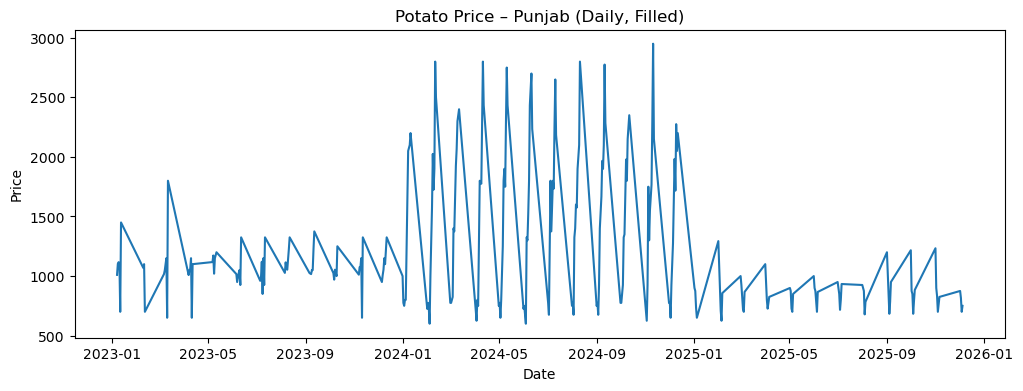

In [14]:


plt.figure(figsize=(12,4))
plt.plot(ts_daily.index, ts_daily['Price'])
plt.title("Potato Price – Punjab (Daily, Filled)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


### Visualize Time Series
Plot the cleaned and interpolated time series data.

In [15]:
def make_daily_ts(df1, crop, state):
    # filter crop & state
    ts = df1[
        (df1['Commodity'] == crop) &
        (df1['STATE'] == state)
    ][['Date', 'Price']].copy()
    
    # sort & set index
    ts = ts.sort_values('Date')
    ts = ts.set_index('Date')
    
    # resample to daily
    ts_daily = ts.resample('D').mean()
    
    # interpolate missing values
    ts_daily['Price'] = ts_daily['Price'].interpolate(method='time')
    ts_daily['Price'] = ts_daily['Price'].ffill().bfill()
    
    return ts_daily


## 5️⃣ Reusable Function: make_daily_ts()

Create a reusable function to generate daily time series for any crop-state combination.

**Steps:**
1. Filter data for specific crop and state
2. Sort by date and set date as index
3. Resample to daily frequency
4. Interpolate missing values using time-based method
5. Forward fill and backward fill any remaining gaps

In [16]:
ts_test = make_daily_ts(df1, 'Potato', 'Punjab')

print(ts_test.shape)
ts_test.head()


(1064, 1)


,Price
Date,
2023-01-07,928.538462
2023-01-08,990.100000
2023-01-09,969.241379
2023-01-10,833.333333
2023-01-11,885.125000


In [17]:
ts_test['Price'].isna().sum()


np.int64(0)

<Axes: title={'center': 'Potato Price - Punjab (Reusable Function)'}, xlabel='Date'>

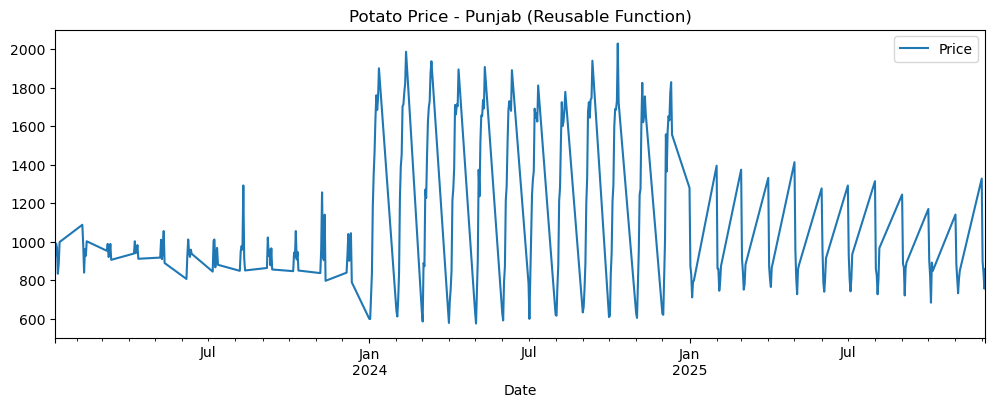

In [18]:
ts_test.plot(figsize=(12,4), title="Potato Price - Punjab (Reusable Function)")


In [19]:
ts_feat = ts_test.copy()

ts_feat['day'] = ts_feat.index.day
ts_feat['month'] = ts_feat.index.month
ts_feat['dayofweek'] = ts_feat.index.dayofweek
ts_feat['weekofyear'] = ts_feat.index.isocalendar().week.astype(int)


## 6️⃣ Feature Engineering

### Temporal Features
Extract time-based features from the date index for ML model training.

In [20]:
lags = [1, 7, 14, 30]

for lag in lags:
    ts_feat[f'lag_{lag}'] = ts_feat['Price'].shift(lag)


### Lag Features
Create features from past prices (1, 7, 14, and 30 days ago).

In [21]:
ts_feat['ma_7'] = ts_feat['Price'].rolling(7).mean()
ts_feat['ma_14'] = ts_feat['Price'].rolling(14).mean()
ts_feat['ma_30'] = ts_feat['Price'].rolling(30).mean()
ts_feat['std_7'] = ts_feat['Price'].rolling(7).std()

### Rolling Statistics
Calculate moving averages and standard deviation for trend analysis.

In [22]:
ts_feat = ts_feat.dropna()

print(ts_feat.shape)
ts_feat.head()


(1034, 13)


,Price,day,month,dayofweek,weekofyear,lag_1,lag_7,lag_14,lag_30,ma_7,ma_14,ma_30,std_7
Date,,,,,,,,,,,,,
2023-02-06,1084.052730,6,2,0,6,1080.605459,1059.921836,1035.790943,928.538462,1073.710918,1061.645471,1024.760259,7.446955
2023-02-07,1087.500000,7,2,1,6,1084.052730,1063.369107,1039.238213,990.100000,1077.158189,1065.092742,1028.006926,7.446955
2023-02-08,984.090909,8,2,2,6,1087.500000,1066.816377,1042.685484,969.241379,1065.340265,1060.907415,1028.501910,36.308091
2023-02-09,839.130435,9,2,3,6,984.090909,1070.263648,1046.132754,833.333333,1032.321234,1046.121535,1028.695147,92.578361
2023-02-10,960.560000,10,2,4,6,839.130435,1073.710918,1049.580025,885.125000,1016.156817,1039.762962,1031.209647,94.014244


### Remove Rows with NaN
Drop rows with missing values created by lag and rolling operations.

In [23]:
# target & features
X = ts_feat.drop(columns=['Price'])
y = ts_feat['Price']

# last 20% as test
split_idx = int(len(ts_feat) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(X_train.shape, X_test.shape)


(827, 12) (207, 12)


## 7️⃣ Model Training

### Train-Test Split
Split the data into training (80%) and testing (20%) sets.

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)




RandomForestRegressor(max_depth=15, min_samples_leaf=5, n_estimators=500,
                      n_jobs=-1, random_state=42)

### Train Random Forest Model
Train a Random Forest Regressor with optimized hyperparameters.

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 31.50863169659781
RMSE: 50.848650353888424


### Model Evaluation
Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

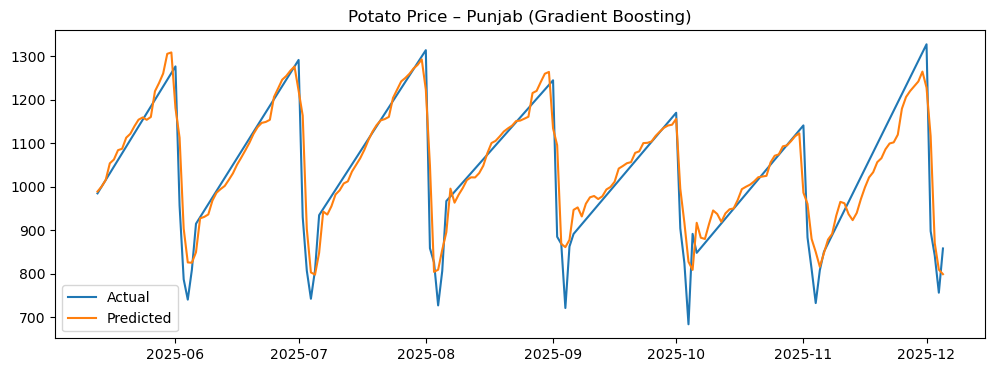

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title("Potato Price – Punjab (Gradient Boosting)")
plt.show()


### Visualize Predictions vs Actual
Plot actual vs predicted prices to assess model performance.

In [28]:
crops = ['Potato', 'Onion', 'Wheat', 'Tomato', 'Rice']
states = df1['STATE'].unique().tolist()

print("Crops:", crops)
print("Number of states:", len(states))


Crops: ['Potato', 'Onion', 'Wheat', 'Tomato', 'Rice']
Number of states: 30


In [30]:
ts_onion_punjab = make_daily_ts(df1, 'Onion', 'Punjab')

print(ts_onion_punjab.shape)
ts_onion_punjab.head()


(1064, 1)


,Price
Date,
2023-01-07,1437.916667
2023-01-08,1599.206897
2023-01-09,2028.607143
2023-01-10,1900.000000
2023-01-11,4159.000000


### Test the make_daily_ts() Function
Verify the function works correctly for different crop-state combinations.

In [31]:
def make_features(ts_daily):
    df_feat = ts_daily.copy()
    
    df_feat['day'] = df_feat.index.day
    df_feat['month'] = df_feat.index.month
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['weekofyear'] = df_feat.index.isocalendar().week.astype(int)

    for lag in [1, 7, 14, 30]:
        df_feat[f'lag_{lag}'] = df_feat['Price'].shift(lag)

    df_feat['ma_7'] = df_feat['Price'].rolling(7).mean()
    df_feat['ma_14'] = df_feat['Price'].rolling(14).mean()
    df_feat['ma_30'] = df_feat['Price'].rolling(30).mean()
    df_feat['std_7'] = df_feat['Price'].rolling(7).std()

    return df_feat.dropna()


## 8️⃣ Reusable Function: make_features()

Complete feature engineering function that creates all required features.

**Features Created:**
- **Temporal**: day, month, dayofweek, weekofyear
- **Lag**: lag_1, lag_7, lag_14, lag_30
- **Rolling**: ma_7, ma_14, ma_30, std_7

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib
import os

os.makedirs("models", exist_ok=True)

def train_model(ts_feat, crop, state):
    X = ts_feat.drop(columns=['Price'])
    y = ts_feat['Price']

    split = int(len(ts_feat) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    model = RandomForestRegressor(
        n_estimators=500,
        max_depth=15,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)

    # save model
    model_path = f"models/{crop}_{state}.pkl"
    joblib.dump(model, model_path)

    return mae, model_path


## 9️⃣ Reusable Function: train_model()

Automated model training function that handles:
1. Feature-target separation
2. Train-test split (80-20)
3. Random Forest training
4. Model evaluation (MAE)
5. Model serialization to disk

In [37]:
# ============================================================
# FINAL CLEAN TRAINING PIPELINE (ALL FIXES INCLUDED)
# ============================================================

import pandas as pd

# -------------------------
# 1. STATE NORMALIZATION
# -------------------------

df1 = df1.copy()

df1['STATE'] = df1['STATE'].str.strip()

state_map = {
    'Chattisgarh': 'Chhattisgarh',
    'Orissa': 'Odisha',
    'Uttrakhand': 'Uttarakhand',
    'Tamilnadu': 'Tamil Nadu',
    'Jammu & Kashmir': 'Jammu and Kashmir'
}

df1['STATE'] = df1['STATE'].replace(state_map)

print("Unique states after normalization:", df1['STATE'].nunique())

# -------------------------
# 2. CONFIGURATION
# -------------------------

CROPS = ['Potato', 'Onion', 'Wheat', 'Tomato', 'Rice']

MIN_DAYS_BY_CROP = {
    'Potato': 365,
    'Onion': 365,
    'Wheat': 365,
    'Tomato': 180,
    'Rice': 180
}

MIN_FEATURE_ROWS_BY_CROP = {
    'Potato': 300,
    'Onion': 300,
    'Wheat': 300,
    'Tomato': 200,
    'Rice': 200
}

MAX_MAE_BY_CROP = {
    'Potato': 150,
    'Onion': 200,
    'Wheat': 50,
    'Tomato': 250,
    'Rice': 100
}

results = []

# -------------------------
# 3. TRAINING LOOP
# -------------------------

for crop in CROPS:
    print(f"\n==============================")
    print(f" Processing crop: {crop}")
    print(f"==============================")

    for state in df1['STATE'].unique():
        try:
            # ---- Build daily series
            ts_daily = make_daily_ts(df1, crop, state)

            if len(ts_daily) < MIN_DAYS_BY_CROP[crop]:
                print(f"SKIP {crop}-{state}: only {len(ts_daily)} days")
                continue

            # ---- Feature engineering
            ts_feat = make_features(ts_daily)

            if len(ts_feat) < MIN_FEATURE_ROWS_BY_CROP[crop]:
                print(
                    f"SKIP {crop}-{state}: insufficient features "
                    f"({len(ts_feat)} rows)"
                )
                continue

            # ---- Train model
            mae, model_path = train_model(ts_feat, crop, state)

            # ---- Quality filters
            if mae < 1:
                print(f"DROP {crop}-{state}: near-zero MAE (flat series)")
                continue

            if mae > MAX_MAE_BY_CROP[crop]:
                print(
                    f"DROP {crop}-{state}: MAE {mae:.2f} "
                    f"> allowed {MAX_MAE_BY_CROP[crop]}"
                )
                continue

            results.append({
                'crop': crop,
                'state': state,
                'mae': mae,
                'rows': len(ts_feat),
                'model_path': model_path
            })

            print(
                f"✓ TRAINED {crop}-{state} | "
                f"Rows: {len(ts_feat)} | MAE: {mae:.2f}"
            )

        except Exception as e:
            print(f"✗ ERROR {crop}-{state}: {e}")

# -------------------------
# 4. FINAL SUMMARY
# -------------------------

results_df = pd.DataFrame(results)

print("\n========== FINAL SUMMARY ==========")
print("Total VALID models trained:", len(results_df))

print("\nBest models:")
print(results_df.sort_values('mae').head(10))

print("\nWorst (still acceptable) models:")
print(results_df.sort_values('mae', ascending=False).head(10))



Unique states after normalization: 26

 Processing crop: Potato
✓ TRAINED Potato-Maharashtra | Rows: 1034 | MAE: 33.43
✓ TRAINED Potato-Uttar Pradesh | Rows: 1034 | MAE: 20.91
✓ TRAINED Potato-Rajasthan | Rows: 1034 | MAE: 26.19
✓ TRAINED Potato-Haryana | Rows: 1034 | MAE: 34.74
✓ TRAINED Potato-West Bengal | Rows: 1034 | MAE: 49.84
✓ TRAINED Potato-Himachal Pradesh | Rows: 1034 | MAE: 52.10
✓ TRAINED Potato-Gujarat | Rows: 1034 | MAE: 47.24
DROP Potato-Meghalaya: MAE 235.93 > allowed 150
✓ TRAINED Potato-Madhya Pradesh | Rows: 1034 | MAE: 30.54
✓ TRAINED Potato-Andhra Pradesh | Rows: 1034 | MAE: 47.12
✓ TRAINED Potato-Kerala | Rows: 1034 | MAE: 118.50
DROP Potato-Nagaland: MAE 174.74 > allowed 150
✓ TRAINED Potato-Odisha | Rows: 1034 | MAE: 70.10
✓ TRAINED Potato-Karnataka | Rows: 1034 | MAE: 74.08
✓ TRAINED Potato-Assam | Rows: 1034 | MAE: 23.91
✓ TRAINED Potato-Punjab | Rows: 1034 | MAE: 31.77
✓ TRAINED Potato-Jammu and Kashmir | Rows: 1034 | MAE: 58.07
✓ TRAINED Potato-Delhi | Rows

## 🔟 PRODUCTION MODEL TRAINING PIPELINE

**Comprehensive training loop for all crop-state combinations**

### Key Features:
- ✅ State name normalization (handles spelling variations)
- ✅ Quality filters by crop type
- ✅ Minimum data requirements (365+ days for Potato/Onion/Wheat, 180+ for Tomato/Rice)
- ✅ MAE thresholds to reject poor models
- ✅ Automated model export to `models/` folder
- ✅ Progress tracking and error handling

### Configuration:
- **Crops**: Potato, Onion, Wheat, Tomato, Rice
- **States**: All available states with sufficient data
- **Model**: Random Forest (500 trees, depth 15)

In [38]:
import os
import joblib

MODEL_DIR = "models"

def get_model_path(crop, state):
    filename = f"{crop}_{state}.pkl"
    path = os.path.join(MODEL_DIR, filename)

    if not os.path.exists(path):
        raise FileNotFoundError(f"No model for {crop} - {state}")

    return path


## 1️⃣1️⃣ PREDICTION FUNCTIONS

### Function: get_model_path()
Locate the saved model file for a specific crop-state combination.

In [39]:
def load_model(crop, state):
    model_path = get_model_path(crop, state)
    model = joblib.load(model_path)
    return model


### Function: load_model()
Load a trained model from disk using joblib.

In [40]:
def get_recent_ts(df, crop, state, days=60):
    ts = make_daily_ts(df, crop, state)

    if len(ts) < days:
        raise ValueError("Not enough historical data")

    return ts.iloc[-days:]


### Function: get_recent_ts()
Retrieve the most recent 60 days of time series data for prediction.

In [41]:
def prepare_latest_features(ts_recent):
    ts_feat = make_features(ts_recent)

    # Take LAST row → represents "today"
    X_latest = ts_feat.drop(columns=['Price']).iloc[-1:]

    return X_latest


### Function: prepare_latest_features()
Generate features from recent data and extract the most recent row for prediction.

In [42]:
def predict_next_day_price(df, crop, state):
    """
    Predict next day's price for given crop and state
    """

    # 1. Load model
    model = load_model(crop, state)

    # 2. Get recent data
    ts_recent = get_recent_ts(df, crop, state)

    # 3. Prepare features
    X_latest = prepare_latest_features(ts_recent)

    # 4. Predict
    predicted_price = model.predict(X_latest)[0]

    return round(float(predicted_price), 2)


### Function: predict_next_day_price()

**Main prediction function** - Predicts the price for the next day.

**Steps:**
1. Load the trained model
2. Get recent 60 days of data
3. Engineer features from recent data
4. Predict using the model
5. Return rounded price

In [43]:
price = predict_next_day_price(
    df=df1,
    crop="Potato",
    state="Uttar Pradesh"
)

print("Predicted next-day price:", price)


Predicted next-day price: 1101.05


### Test Next Day Prediction
Test the prediction function with a sample crop-state combination.

In [44]:
def forecast_prices(df, crop, state, days=7):
    """
    Forecast prices for next N days using recursive strategy
    """

    model = load_model(crop, state)
    ts = make_daily_ts(df, crop, state)

    forecasts = []

    for _ in range(days):
        ts_recent = ts.iloc[-60:]
        ts_feat = make_features(ts_recent)
        X_latest = ts_feat.drop(columns=['Price']).iloc[-1:]

        next_price = model.predict(X_latest)[0]
        next_price = float(next_price)

        next_date = ts.index[-1] + pd.Timedelta(days=1)

        ts.loc[next_date] = next_price
        forecasts.append((next_date.date(), round(next_price, 2)))

    return forecasts


## 1️⃣2️⃣ MULTI-DAY FORECASTING

### Function: forecast_prices()

**Recursive forecasting function** - Predicts prices for multiple days ahead.

**Recursive Strategy:**
1. Predict next day price
2. Append prediction to time series
3. Use updated series to predict next day
4. Repeat for N days

**Returns:** List of (date, price) tuples

In [45]:
forecast = forecast_prices(
    df=df1,
    crop="Potato",
    state="Uttar Pradesh",
    days=7
)

for d, p in forecast:
    print(d, "→", p)


2025-12-06 → 1101.05
2025-12-07 → 1133.17
2025-12-08 → 1143.68
2025-12-09 → 1152.36
2025-12-10 → 1173.95
2025-12-11 → 1173.32
2025-12-12 → 1206.61


### Test Multi-Day Forecast
Generate a 7-day price forecast.

In [46]:
def get_trend(forecasts):
    prices = [p for _, p in forecasts]

    delta = prices[-1] - prices[0]
    pct_change = (delta / prices[0]) * 100

    if pct_change > 5:
        trend = "Strong Upward 📈"
    elif pct_change > 2:
        trend = "Upward 📈"
    elif pct_change < -5:
        trend = "Strong Downward 📉"
    elif pct_change < -2:
        trend = "Downward 📉"
    else:
        trend = "Stable ➝"

    return round(pct_change, 2), trend


## 1️⃣3️⃣ TREND ANALYSIS

### Function: get_trend()

Analyze price trend from forecast data and classify it.

**Trend Classification:**
- **Strong Upward** 📈: > +5% change
- **Upward** 📈: +2% to +5% change
- **Stable** ➝: -2% to +2% change
- **Downward** 📉: -5% to -2% change
- **Strong Downward** 📉: < -5% change

**Returns:** (percent_change, trend_description)

In [47]:
def forecast_summary(df, crop, state, days=7):
    forecast = forecast_prices(df, crop, state, days)
    pct_change, trend = get_trend(forecast)

    start_price = forecast[0][1]
    end_price = forecast[-1][1]

    summary = {
        "crop": crop,
        "state": state,
        "days": days,
        "start_price": start_price,
        "end_price": end_price,
        "percent_change": pct_change,
        "trend": trend,
        "daily_forecast": forecast
    }

    return summary


### Function: forecast_summary()

**Complete forecast summary function** - Combines forecasting and trend analysis.

**Returns a dictionary with:**
- crop, state, days
- start_price, end_price
- percent_change, trend description
- daily_forecast (list of date-price pairs)

In [48]:
summary = forecast_summary(
    df=df1,
    crop="Potato",
    state="Uttar Pradesh",
    days=7
)

summary


{'crop': 'Potato',
 'state': 'Uttar Pradesh',
 'days': 7,
 'start_price': 1101.05,
 'end_price': 1206.61,
 'percent_change': 9.59,
 'trend': 'Strong Upward 📈',
 'daily_forecast': [(datetime.date(2025, 12, 6), 1101.05),
  (datetime.date(2025, 12, 7), 1133.17),
  (datetime.date(2025, 12, 8), 1143.68),
  (datetime.date(2025, 12, 9), 1152.36),
  (datetime.date(2025, 12, 10), 1173.95),
  (datetime.date(2025, 12, 11), 1173.32),
  (datetime.date(2025, 12, 12), 1206.61)]}

### Test Complete Forecast Summary
Generate a complete forecast summary with trend analysis.

---

## ✅ Notebook Complete!

### Summary of Trained Models
All models have been trained and saved to the `models/` directory.

### Next Steps:
1. ✅ Models are ready for production use
2. ✅ Use `predict_next_day_price()` for single-day predictions
3. ✅ Use `forecast_summary()` for multi-day forecasts with trends
4. ✅ Deploy using FastAPI (see `app.py`)

### Model Files:
- 92 trained models (`.pkl` files)
- One model per crop-state combination
- Random Forest with 500 estimators

**Developer**: Suraj Singh  
**Email**: surajsingh@gmail.com